In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
path1 = r"C:\Users\ADMIN\Downloads\GOLD.csv"
gld = pd.read_csv(path1)
path2 = r"C:\Users\ADMIN\Downloads\SILVER.csv"
slv = pd.read_csv(path2)
path3 = r"C:\Users\ADMIN\Downloads\S&P500.csv"
sp500 = pd.read_csv(path3)
path4 = r"C:\Users\ADMIN\Downloads\USD INDEX.csv"
dxy = pd.read_csv(path4)

In [17]:
def clean_price_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    
    # Keep only Close price
    if 'Close' in df.columns:
        df = df[['Close']]
    elif 'Price' in df.columns:
        df = df[['Price']].rename(columns={'Price':'Close'})
    
    return df

gld = clean_price_data(gld)
slv = clean_price_data(slv)
sp500 = clean_price_data(sp500)
dxy = clean_price_data(dxy)

In [18]:
end_date = gld.index.max()
start_date = end_date - pd.DateOffset(months=6)

gld = gld.loc[start_date:]
slv = slv.loc[start_date:]
sp500 = sp500.loc[start_date:]
dxy = dxy.loc[start_date:]

In [19]:
# Combine datasets using inner join (common dates only)
combined = gld[['Close']].join(
    slv[['Close']], how='inner', lsuffix='_Gold', rsuffix='_Silver'
)

combined = combined.join(
    sp500[['Close']], how='inner'
)

combined = combined.join(
    dxy[['Close']], how='inner', rsuffix='_DXY'
)

combined.head()

,Close_Gold,Close_Silver,Close,Close_DXY
Date,,,,
2025-07-29,306.25,34.66,6370.859863,98.89
2025-07-30,300.96,33.51,6362.899902,99.82
2025-07-31,302.96,33.32,6339.390137,99.97
2025-08-01,309.11,33.59,6238.009766,99.14
2025-08-04,310.91,33.98,6329.939941,98.78


In [20]:
combined.columns = ['Gold', 'Silver', 'SP500', 'DXY']
combined.head()

,Gold,Silver,SP500,DXY
Date,,,,
2025-07-29,306.25,34.66,6370.859863,98.89
2025-07-30,300.96,33.51,6362.899902,99.82
2025-07-31,302.96,33.32,6339.390137,99.97
2025-08-01,309.11,33.59,6238.009766,99.14
2025-08-04,310.91,33.98,6329.939941,98.78


In [21]:
returns = combined.pct_change() * 100
returns.head()

,Gold,Silver,SP500,DXY
Date,,,,
2025-07-29,NaN,NaN,NaN,NaN
2025-07-30,-1.727347,-3.317946,-0.124943,0.940439
2025-07-31,0.664540,-0.566995,-0.369482,0.150270
2025-08-01,2.029971,0.810324,-1.599213,-0.830249
2025-08-04,0.582317,1.161060,1.473710,-0.363123


In [23]:
worst_day = returns.min()
worst_day

Gold     -6.426888
Silver   -8.235541
SP500    -2.711167
DXY      -0.912594
dtype: float64

In [24]:
drawdown = (combined / combined.cummax() - 1) * 100
drawdown.min()

Gold     -10.127744
Silver   -13.768558
SP500     -5.110085
DXY       -4.000798
dtype: float64

In [25]:
volatility_7d = returns.rolling(7).std()
volatility_7d.max()

Gold      3.465509
Silver    6.401667
SP500     1.401347
DXY       0.593520
dtype: float64

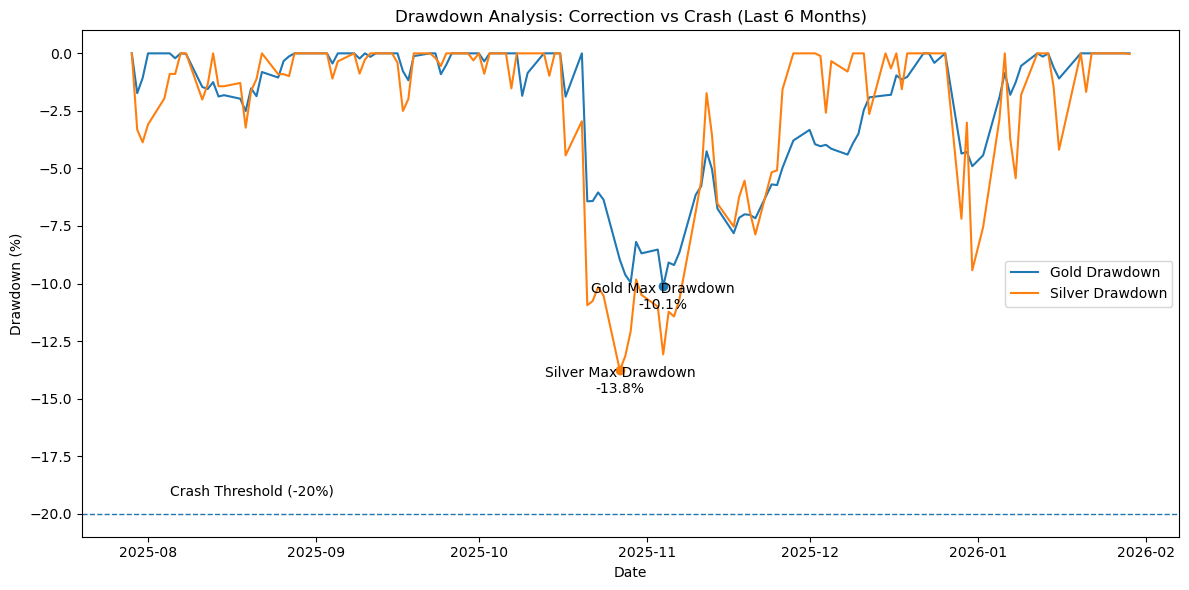

In [29]:
plt.figure(figsize=(12,6))

plt.plot(drawdown.index, drawdown['Gold'], label='Gold Drawdown')
plt.plot(drawdown.index, drawdown['Silver'], label='Silver Drawdown')

# Crash threshold
plt.axhline(-20, linestyle='--', linewidth=1)
plt.text(drawdown.index[5], -19.2, "Crash Threshold (-20%)", fontsize=10)

# Annotate max drawdowns
gold_min = drawdown['Gold'].min()
silver_min = drawdown['Silver'].min()

gold_min_date = drawdown['Gold'].idxmin()
silver_min_date = drawdown['Silver'].idxmin()

plt.scatter(gold_min_date, gold_min)
plt.scatter(silver_min_date, silver_min)

plt.text(gold_min_date, gold_min - 1,
         f"Gold Max Drawdown\n{gold_min:.1f}%",
         ha='center')

plt.text(silver_min_date, silver_min - 1,
         f"Silver Max Drawdown\n{silver_min:.1f}%",
         ha='center')

plt.title("Drawdown Analysis: Correction vs Crash (Last 6 Months)")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.tight_layout()
plt.show()

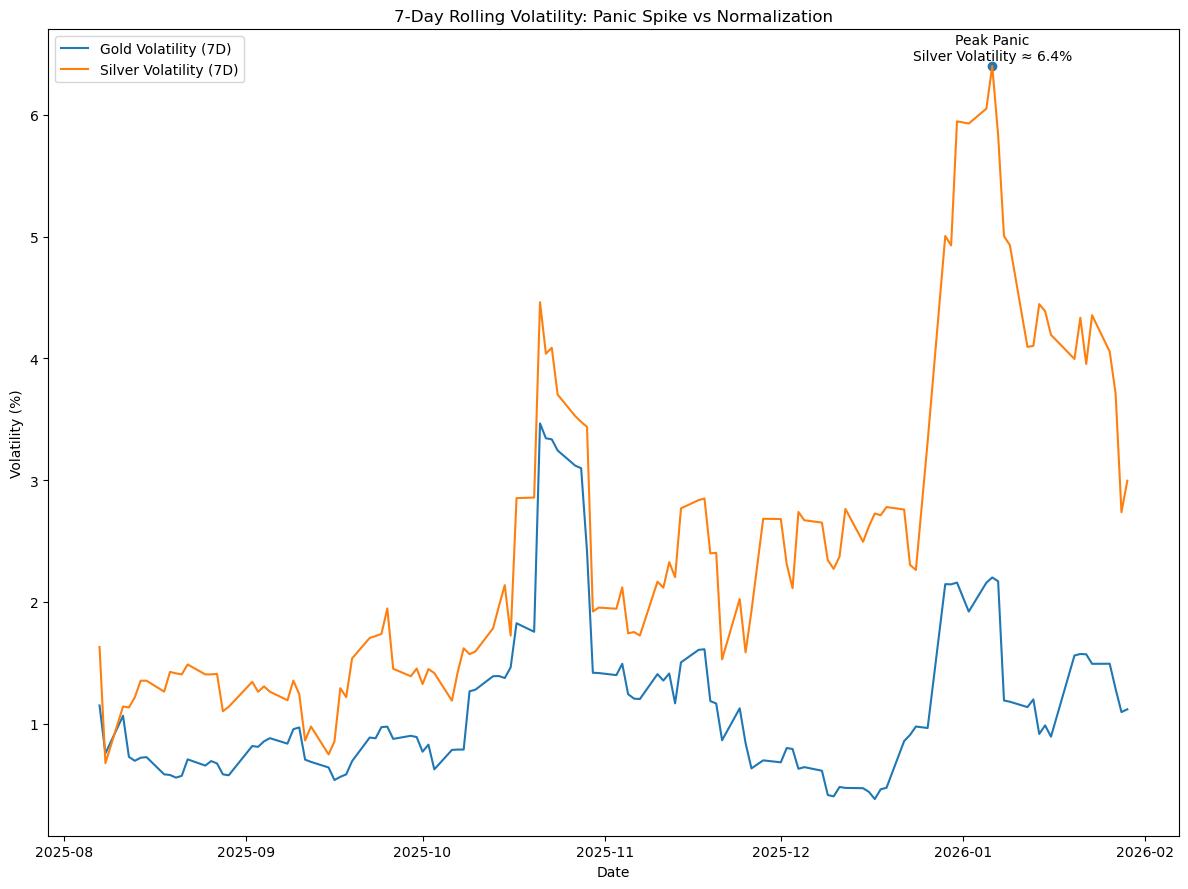

In [36]:
plt.figure(figsize=(12,9))

plt.plot(volatility_7d.index, volatility_7d['Gold'], label='Gold Volatility (7D)')
plt.plot(volatility_7d.index, volatility_7d['Silver'], label='Silver Volatility (7D)')

# Highlight peak volatility
silver_vol_max = volatility_7d['Silver'].max()
silver_vol_date = volatility_7d['Silver'].idxmax()

plt.scatter(silver_vol_date, silver_vol_max)
plt.text(silver_vol_date, silver_vol_max + 0.05,
         f"Peak Panic\nSilver Volatility ≈ {silver_vol_max:.1f}%",
         ha='center')

plt.title("7-Day Rolling Volatility: Panic Spike vs Normalization")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.tight_layout()
plt.show()

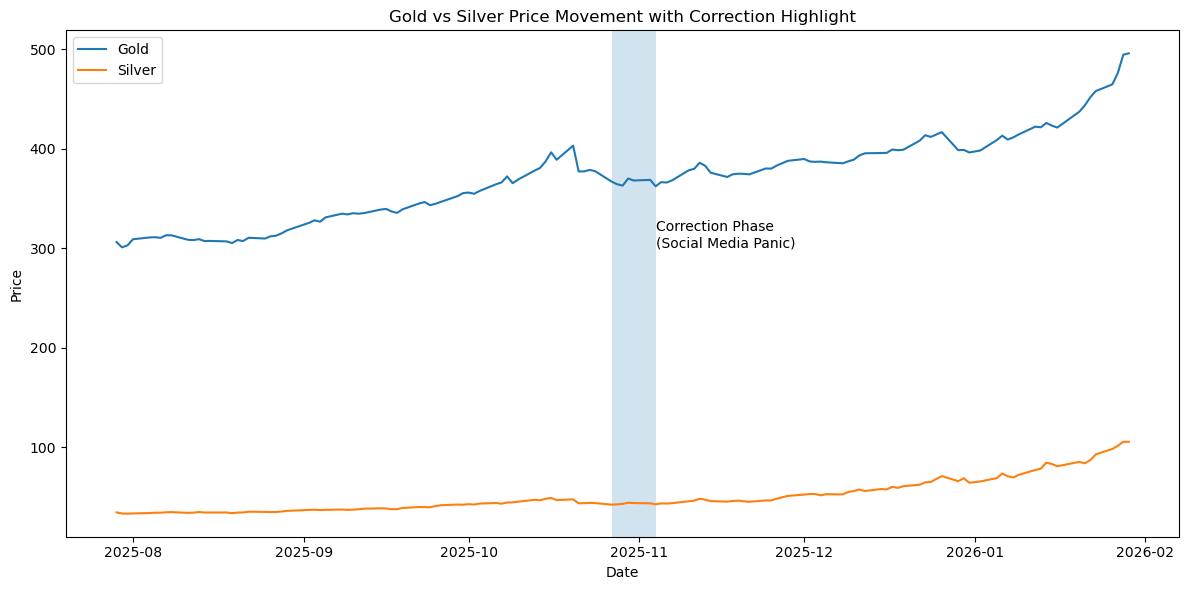

In [37]:
plt.figure(figsize=(12,6))

plt.plot(combined.index, combined['Gold'], label='Gold')
plt.plot(combined.index, combined['Silver'], label='Silver')

# Highlight correction period
plt.axvspan(gold_min_date, silver_min_date, alpha=0.2)

plt.text(gold_min_date, combined['Gold'].min(),
         "Correction Phase\n(Social Media Panic)",
         fontsize=10)

plt.title("Gold vs Silver Price Movement with Correction Highlight")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()